In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from torchsummary import summary
import onnx
import onnxruntime
# import tensorflow_addons as tfa
from onnx_tf.backend import prepare
import sys
from tqdm.notebook import tqdm

#  enable benchmarking
torch.backends.cudnn.benchmark = True

# print(mydevice)

2022-12-05 11:15:23.677686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 11:15:23.959911: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-05 11:15:25.233095: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/

In [2]:
class cnn(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.rel = nn.ReLU()
        self.conv0 = nn.Conv2d(1,1,7) # 22*22
        self.conv1 = nn.Conv2d(1,1,7) # 16*16
        self.conv2 = nn.Conv2d(1,1,5) # 11*11
        self.conv12 = nn.Conv2d(1,1,3) # 9*9         # 12*12
        self.fc1 = nn.Linear(10*10, 10)
        self.flat = nn.Flatten()

        #  initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv0(x)
        x = self.rel(x)
        x = self.conv1(x)
        x = self.rel(x)
        x = self.conv2(x)
        x = self.rel(x)
        x = self.conv12(x)
        x = self.rel(x)
        x = self.flat(x)
        x = self.fc1(x)
        return x

model = cnn()

summary(model, (1,28,28))

optim = torch.optim.AdamW(model.parameters(), lr=0.001)
critereon = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=3, verbose=True)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 22, 22]              50
              ReLU-2            [-1, 1, 22, 22]               0
            Conv2d-3            [-1, 1, 16, 16]              50
              ReLU-4            [-1, 1, 16, 16]               0
            Conv2d-5            [-1, 1, 12, 12]              26
              ReLU-6            [-1, 1, 12, 12]               0
            Conv2d-7            [-1, 1, 10, 10]              10
              ReLU-8            [-1, 1, 10, 10]               0
           Flatten-9                  [-1, 100]               0
           Linear-10                   [-1, 10]           1,010
Total params: 1,146
Trainable params: 1,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total

In [3]:
batch_size = 64
#  load data
train_data = datasets.MNIST(root='data', train=True, transform=T.ToTensor(), download=True)
test_data = datasets.MNIST(root='data', train=False, transform=T.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [4]:

best_loss = np.inf

train_losses = []
tain_accs = []
test_losses = []
test_accs = []

weights = []
biases = []
grads = []


# train
for epoch in tqdm(range(20)):
    model.train()
    total_loss = 0
    total_acc = 0
    with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
        for x, y in train_loader:
            pbar.update(1)
            x = x
            y = y
            optim.zero_grad(set_to_none = True)
            y_ = model(x)
            loss = critereon(y_, y)
            total_acc += (y_.argmax(dim=1) == y).sum().item()
            loss.backward()
            optim.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))
        tain_accs.append(total_acc / len(train_data))
        pbar.set_description(f"epoch {epoch} train acc {total_acc / len(train_data):.3f}")
        pbar.refresh()
    
    # test
    model.eval()
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        with tqdm(total=len(test_loader), file=sys.stdout) as pbar:
            for x, y in test_loader:
                pbar.update(1)
                x = x
                y = y
                y_ = model(x)
                loss = critereon(y_, y)
                total_acc += (y_.argmax(dim=1) == y).sum().item()
                total_loss += loss.item()
            test_losses.append(total_loss / len(test_loader))
            test_accs.append(total_acc / len(test_data))
            pbar.set_description(f"epoch {epoch} test acc {total_acc / len(test_data):.3f}")
            pbar.refresh()
            if total_loss < best_loss:
                best_loss = total_loss
                torch.save(model.state_dict(), "cnn.pt")
        scheduler.step(total_loss / len(test_loader))



  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0 test acc 0.842: 100%|██████████| 157/157 [00:01<00:00, 145.20it/s]

  5%|▌         | 1/20 [00:13<04:11, 13.26s/it]


epoch 1 test acc 0.858: 100%|██████████| 157/157 [00:01<00:00, 141.80it/s]

 10%|█         | 2/20 [00:27<04:04, 13.60s/it]

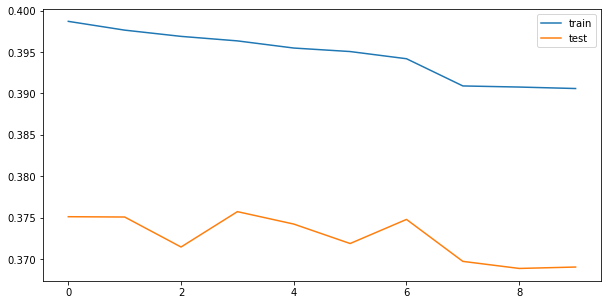

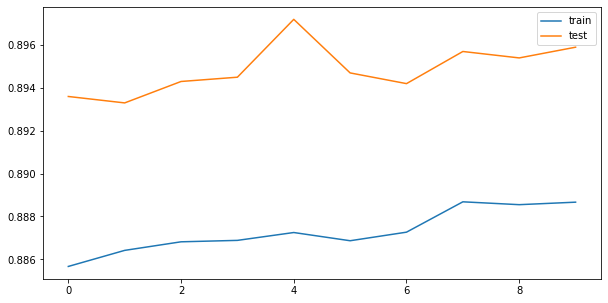

In [ ]:
# graph loss
plt.figure(figsize = (10, 5))
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.show()

# graph acc
plt.figure(figsize = (10, 5))
plt.plot(tain_accs, label="train")
plt.plot(test_accs, label="test")
plt.legend()
plt.show()


 96%|█████████▌| 151/157 [00:01<00:00, 137.80it/s]test acc 0.895
test loss 0.3717740790764238
class 0 acc 0.966
class 1 acc 0.976
class 2 acc 0.855
class 3 acc 0.893
class 4 acc 0.901
class 5 acc 0.830
class 6 acc 0.913
class 7 acc 0.888
class 8 acc 0.849
class 9 acc 0.867
100%|██████████| 157/157 [00:01<00:00, 132.14it/s]


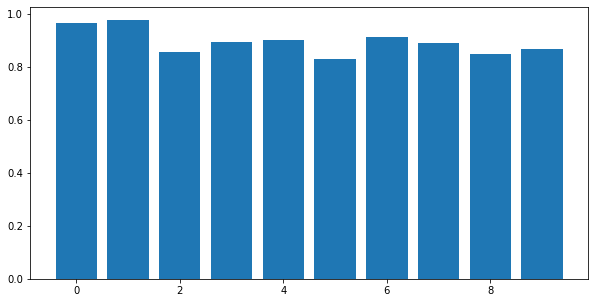

In [ ]:
#  loda the best model
model.load_state_dict(torch.load("cnn.pt"))

#  evaluate
model.eval()
with torch.no_grad():
    total_loss = 0
    total_acc = 0
    class_acc = np.zeros(10)
    class_num = np.zeros(10)
    with tqdm(total=len(test_loader), file=sys.stdout) as pbar:
        for x, y in test_loader:
            pbar.update(1)
            x = x
            y = y
            y_ = model(x)
            loss = critereon(y_, y)
            total_acc += (y_.argmax(dim=1) == y).sum().item()
            total_loss += loss.item()
            for i in range(len(y)):
                class_acc[y[i]] += (y_.argmax(dim=1)[i] == y[i]).item()
                class_num[y[i]] += 1
        print(f"test acc {total_acc / len(test_data):.3f}")
        print(f"test loss {total_loss / len(test_loader)}")
        for i in range(10):
            print(f"class {i} acc {class_acc[i] / class_num[i]:.3f}")
#  graph the acc
plt.figure(figsize = (10, 5))
plt.bar(range(10), class_acc / class_num)
plt.show()


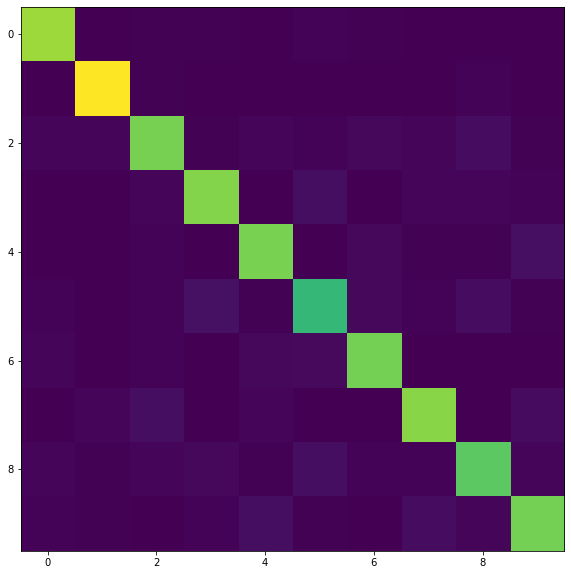

In [ ]:
#  compute confusion matrix
confusion_matrix = np.zeros((10, 10))
with torch.no_grad():
    for x, y in test_loader:
        x = x
        y = y
        y_ = model(x)
        for i in range(len(y)):
            confusion_matrix[y[i]][y_.argmax(dim=1)[i]] += 1
#  graph the confusion matrix
plt.figure(figsize = (10, 10))
plt.imshow(confusion_matrix)
plt.show()


In [ ]:
#  export to onnx
dummy_input = torch.randn(1, 1, 28, 28, device='cpu')
torch.onnx.export(model, dummy_input, "cnn.onnx", verbose=True, input_names = ['input'], output_names = ['output'], opset_version=11)

#  check the onnx model
onnx_model = onnx.load("cnn.onnx")
print(onnx.checker.check_model(onnx_model))
print()
print(onnx.helper.printable_graph(onnx_model.graph))


Exported graph: graph(%input : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %conv0.weight : Float(1, 1, 7, 7, strides=[49, 49, 7, 1], requires_grad=1, device=cpu),
      %conv0.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %conv1.weight : Float(1, 1, 7, 7, strides=[49, 49, 7, 1], requires_grad=1, device=cpu),
      %conv1.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %conv2.weight : Float(1, 1, 5, 5, strides=[25, 25, 5, 1], requires_grad=1, device=cpu),
      %conv2.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %conv12.weight : Float(1, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cpu),
      %conv12.bias : Float(1, strides=[1], requires_grad=1, device=cpu),
      %fc1.weight : Float(10, 100, strides=[100, 1], requires_grad=1, device=cpu),
      %fc1.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %/conv0/Conv_output_0 : Float(1, 1, 22, 22, strides=[484, 484, 22, 1], 

In [ ]:
#  from onnx to tf
tf_rep = prepare(onnx.load("cnn.onnx"))
tf_rep.export_graph('cnn.pb')

x = torch.randn(1, 1, 28, 28, requires_grad = False)

def representative_dataset_gen():
    for _ in range(100):
        yield [x]

converter = tf.lite.TFLiteConverter.from_saved_model("cnn.pb")
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS_INT8, # enable TensorFlow Lite ops.
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()

#  save the model
open("cnn.tflite", "wb").write(tflite_model)


INFO:tensorflow:Assets written to: cnn.pb/assets


INFO:tensorflow:Assets written to: cnn.pb/assets
2022-12-05 10:19:07.250677: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-05 10:19:07.250732: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-05 10:19:07.250910: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn.pb
2022-12-05 10:19:07.251624: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-05 10:19:07.251642: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn.pb
2022-12-05 10:19:07.253373: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-12-05 10:19:07.272312: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: cnn.pb
2022-12-05 10:19:07.279698: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: succes

5000

In [ ]:
# #  test the tflite model
# interpreter = tf.lite.Interpreter(model_path="cnn.tflite")
# interpreter.allocate_tensors()
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# def to_tf(x):
#     return x[0].numpy().reshape(input_details[0]['shape'])

# total_acc = 0
# class_acc= np.zeros(10)
# class_num = np.zeros(10)
# with tqdm(total=len(test_loader), file=sys.stdout) as pbar:
#     for x, y in test_loader:
#         pbar.update(1)
#         interpreter.set_tensor(input_details[0]['index'], to_tf(x))
#         interpreter.invoke()
#         y_ = interpreter.get_tensor(output_details[0]['index'])
#         total_acc += np.sum((y_.argmax(axis=1) == y))
#         for i in range(len(y)):
#             class_acc[y[i]] += (y_.argmax(axis=1)[i] == y[i])
#             class_num[y[i]] += 1
#     print(f"test acc {total_acc / len(test_data):.3f}")
#     for i in range(10):
#         print(f"class {i} acc {class_acc[i] / class_num[i]:.3f}")


  1%|          | 1/157 [00:00<00:02, 68.66it/s]


IndexError: index 1 is out of bounds for axis 0 with size 1